# Impact of variants

We want to infer the effect of different variants onto the reproduction number. Given the positive tested COVID cases in a country we can infer the overall non variant specific effective spreading rate/reproduction number as described in \cite{dehning2020inferring}. 

Now let $y_v$ be the number of sequenced PCR tests, which correspond to variant $v$, let $n$ be the total number of sequenced tests and $\tau_{v,t}$ the relative fraction of the variant $v$ at timepoint $t$.
Assuming an independent sampling of the sequenced cases, the number of samples of a given variant $v$ is given by a Binomial distribution:

\begin{align}
 y_{v,t} \sim \text{Bin}(\tau_{v,t},n_t) \quad \forall v,t.
\end{align}


### Preprocess data

In [1]:
import sys
sys.path.append("./covid19_inference")
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import covid19_inference

n_threads = str(4) # per process
n_processes = 8
os.environ["MKL_NUM_THREADS"] = n_threads
os.environ["OMP_NUM_THREADS"] = n_threads
os.environ["NUMEXPR_NUM_THREADS"] = n_threads
os.environ["OPENBLAS_NUM_THREADS"] = n_threads

# Load data variants
variants = pd.read_excel("./data/Chile_Variants_Updated_070721.xlsx",sheet_name="Variants_Count")
variants = variants.set_index('Lineage').T
variants.index.name = "Week"
variants.index = pd.to_datetime(variants.index + '-1', format='%V_%G-%u')
variants = variants.iloc[0:-1]

# Load casenumbers chile and sum over weeks
jhu = covid19_inference.data_retrieval.JHU(True)
new_cases_obs = jhu.get_new(country="Chile",data_begin=variants.index[0],data_end=variants.index[-1])

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [35]:
import itertools

possible_params_0 = ["SIR","kernelized_spread"]
possible_params_1 = ["beta","binom","dirichlet"]
list(itertools.combinations_with_replacement(possible_params_0, 2))

[('SIR', 'SIR'),
 ('SIR', 'kernelized_spread'),
 ('kernelized_spread', 'kernelized_spread')]

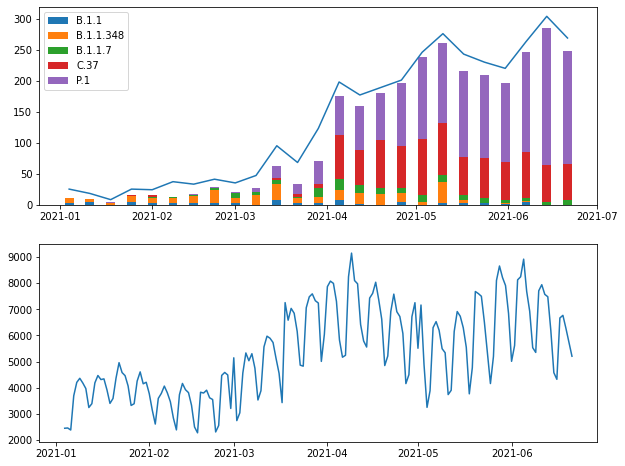

In [2]:
fig, axes = plt.subplots(2,1,figsize=(10,8))

s=0
for c in variants.columns:
    if c == "N_Total":
        continue
    axes[0].bar(variants.index,variants[c],width=3,label=c,bottom=s)
    s += variants[c]
axes[0].plot(variants.index,variants["N_Total"])
axes[0].legend()
axes[1].plot(new_cases_obs.index,new_cases_obs)

### Model variables and utils

In [7]:
# Data begin/end
data_begin = new_cases_obs.index[0]
data_end = new_cases_obs.index[-1]

# Define changepoints (we define all vars to surpress the automatic prints)
def get_cps(data_begin, data_end):
    change_points = [
    ]
    for day in pd.date_range(start=data_begin, end=data_end):
        if day.weekday() == 6:
            # Add cp
            change_points.append(
                dict(  # one possible change point every sunday
                    pr_mean_date_transient=day,
                    pr_sigma_date_transient=1.5,
                    pr_sigma_lambda=0.2,  # wiggle compared to previous point
                    relative_to_previous=True,
                    pr_factor_to_previous=1.0,
                    pr_sigma_transient_len=0.5,
                    pr_median_transient_len=4,
                    pr_median_lambda=0.125,
                )
            )
    return change_points

def day_to_week_matrix(sim_begin, sim_end, weeks, fill=False):
    """
    Returns the matrix mapping a day to an week.
    Does more or less the same as pandas resample but we can use it in 
    the model.
    
    Parameters
    ----------
    sim_begin : datetime
    sim_end : datetime
    weeks : array-like, datetimes
        Begining date of week. Normally variants.index
    fill : bool
        Wheater or not to fill the not defined datapoints with ones
    Interval
    [first_week_day,first_week_day+7)
    """
    days = pd.date_range(sim_begin, sim_end)
    m = np.zeros((len(days),len(weeks)))
    for i, d in enumerate(days):
        for j, week_begin in enumerate(weeks):
            week_end = week_begin+timedelta(days=7)
            #print(week_begin)
            #print(week_end)
            if d >= week_begin and d < week_end:
                m[i,j] = 1
                
        if fill:
            if d < weeks[0]:
                m[i,0] = 1
            if d >= weeks[-1]:
                m[i,-1] = 1
    return m
    
params = {
    "new_cases_obs": new_cases_obs,
    "data_begin": data_begin,
    "fcast_len": 10,
    "diff_data_sim": 16,
    "N_population": 19276715, # population chile
}
variant_names = ["B.1.1","B.1.1.348","B.1.1.7","C.37","P.1"]

pr_delay = 10

### Model definition

In [26]:
from covid19_inference import Cov19Model
from covid19_inference.model import (
    lambda_t_with_sigmoids,
    uncorrelated_prior_I,
    SIR,
    week_modulation,
    student_t_likelihood,
    delay_cases,
    kernelized_variants,
    SIR_variants
)
import pymc3 as pm
import theano.tensor as tt

In [33]:
a = np.ones((11,1,5))

tt.as_tensor(a)

tt.zeros_like(a)

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [17]:
# Enable test value printing
#theano.config.print_test_value = True

with Cov19Model(**params) as this_model:
    
    """
    Basic spreading dynamics modeled alike to our publication:
    "Inferring change points in the spread of COVID-19
    reveals the effectiveness of interventions"
    see https://science.sciencemag.org/content/369/6500/eabb9789.full
    """
    
    # Get base reproduction number/spreading rate
    lambda_t_log = lambda_t_with_sigmoids(
        change_points_list=get_cps(this_model.data_begin,this_model.data_end),
        pr_median_lambda_0=1/8,
        name_lambda_t="lambda_t",
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    
    f = pm.Lognormal(name="f_v",mu=0.01,sigma=1,shape=(len(variant_names)))
    f = f*np.array([1,1,0,1,1])+np.array([0,0,1,0,0])
    
    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    #prior_I = uncorrelated_prior_I(
    #    lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    #)
    
    new_cases_v = SIR_variants(lambda_t_log=lambda_t_log, mu=mu,f=f)
    
    pm.Deterministic("new_cases_v",new_cases_v)
    #new_cases = kernelized_variants(tau=tau,lambda_t_log=lambda_t_log,f=f)
    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = delay_cases(
        cases=new_cases_v.sum(axis=1),
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )
    
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = week_modulation(cases=new_cases, name_cases="new_cases")
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    student_t_likelihood(cases=new_cases)
    
    # Likelihood for variants data
    y = pm.Data("y_obs", np.array(variants[variant_names]))
    n = pm.Data("n_obs", np.stack([np.array(variants["N_Total"])]*len(variant_names),axis=1))
    
    # Calculate daily tau
    tau = new_cases_v/new_cases_v.sum(axis=1)[:,np.newaxis]
    pm.Deterministic("tau",tau)
    
    # Map daily tau to match weekly data
    mapping = day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index)
    tau_w = tau.T.dot(mapping).T / 7
    pm.Deterministic("tau_w",tau_w)
    
    # Likelihood for variants
    logp = pm.Beta.dist(alpha=y+1,beta=n-y+1).logp(tau_w)
    error = pm.Potential("error_tau",logp)
    
    # Variant 2
    #_ = pm.Binomial("tau_w_obs", p=tau_w, observed=y, n=n,shape=(len(variants),len(variant_names)))
    
    
    
    
# Check day to week
day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index, fill=True)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


[2450. 2460. 2382. 3693. 4205. 4361. 4181. 3969. 3243. 3390. 4187. 4468.
 4313. 4339. 3918. 3401. 3589. 4367. 4959. 4581. 4463. 4068. 3322. 3388.
 4255. 4606. 4151. 4209. 3779. 3147. 2610. 3592. 3782. 4063. 3804. 3464.
 2839. 2387. 3731. 4164. 3925. 3813. 3332. 2498. 2275. 3828. 3797. 3906.
 3615. 3549. 2308. 2555. 4472. 4585. 4489. 3207. 5145. 2742. 3040. 4567.
 5331. 5033. 5302. 4748. 3531. 3885. 5563. 5973. 5894. 5731. 5121. 4551.
 3430. 7257. 6584. 7036. 6850. 6155. 4864. 4825. 7060. 7478. 7592. 7330.
 7241. 5008. 6046. 7868. 8079. 7993. 7307. 5827. 5168. 5242. 8248. 9151.
 8101. 7977. 6421. 5790. 5557. 7431. 7613. 8037. 7370. 6622. 4849. 5214.
 6917. 7582. 6909. 6725. 6078. 4158. 4499. 6720. 7254. 5510. 7165. 4895.
 3249. 3885. 6299. 6530. 6198. 5493. 5339. 3738. 3902. 6153. 6915. 6736.
 6296. 5548. 3766. 4767. 7682. 7602. 7500. 6505. 5343. 4160. 5197. 8105.
 8658. 8216. 7910. 6839. 5011. 5616. 8128. 8245. 8920. 7690. 6928. 5533.
 5351. 7709. 7942. 7573. 7481. 6190. 4576. 4322. 66

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Sampling

In [ ]:
from pymc3 import sample
trace = sample(
    model=this_model,
    return_inferencedata=True,
    cores=n_processes,
    chains=4,
    draws=2000,
    tune=2000,
)

INFO     [pymc3] Auto-assigning NUTS sampler...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Multiprocess sampling (4 chains in 8 jobs)
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin, f_v, mu, transient_len_24_log_, transient_len_23_log_, transient_len_22_log_, transient_len_21_log_, transient_len_20_log_, transient_len_19_log_, transient_len_18_log_, transient_len_17_log_, transient_len_16_log_, transient_len_15_log_, transient_len_14_log_, transient_len_13_log_, transient_len_12_log_, transient_len_11_log_, transient_len_10_log_, transient_len_9_log_, transient_len_8_log_, transient_len_7_log_, transient_len_6_log_, transient_len_5_log_, transient_len_4_log_, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_24, transient_day_23, transient_day_22, transient_day_21, transient_day_20, transient_day_19, transient_day_18, transient_day_17, transient_day_16, transient_day_15, 

In [20]:
import pickle
# Save the trace (maybe we want to load it at a later point)
#with open("trace_beta.pickle", 'wb') as f:
#    (this_model,trace) = pickle.load(f)


In [ ]:
with Cov19Model(**params) as this_model:
    
    """
    Basic spreading dynamics modeled alike to our publication:
    "Inferring change points in the spread of COVID-19
    reveals the effectiveness of interventions"
    see https://science.sciencemag.org/content/369/6500/eabb9789.full
    """
    
    # Get base reproduction number/spreading rate
    lambda_t_log = lambda_t_with_sigmoids(
        change_points_list=get_cps(this_model.data_begin,this_model.data_end),
        pr_median_lambda_0=1/8,
        name_lambda_t="lambda_t",
    )

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    
    f = pm.Lognormal(name="f_v",mu=0.01,sigma=1,shape=(len(variant_names)))
    f = f*np.array([1,1,0,1,1])+np.array([0,0,1,0,0])
    
    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.SIR
    #prior_I = uncorrelated_prior_I(
    #    lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
    #)
    
    new_cases_v = SIR_variants(lambda_t_log=lambda_t_log, mu=mu,f=f)
    
    pm.Deterministic("new_cases_v",new_cases_v)
    #new_cases = kernelized_variants(tau=tau,lambda_t_log=lambda_t_log,f=f)
    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = delay_cases(
        cases=new_cases_v.sum(axis=1),
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_median_of_width=0.3,
    )
    
    
    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = week_modulation(cases=new_cases, name_cases="new_cases")
    
    # Define the likelihood, uses the new_cases_obs set as model parameter
    student_t_likelihood(cases=new_cases)
    
    # Likelihood for variants data
    y = pm.Data("y_obs", np.array(variants[variant_names]))
    n = pm.Data("n_obs", np.stack([np.array(variants["N_Total"])]*len(variant_names),axis=1))
    
    # Calculate daily tau
    tau = new_cases_v/new_cases_v.sum(axis=1)[:,np.newaxis]
    pm.Deterministic("tau",tau)
    
    # Map daily tau to match weekly data
    mapping = day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index)
    tau_w = tau.T.dot(mapping).T / 7 #mean tau value
    pm.Deterministic("tau_w",tau_w)
    
    # Likelihood for variants
    #logp = pm.Beta.dist(alpha=y+1,beta=n-y+1).logp(tau_w)
    #error = pm.Potential("error_tau",logp)
    
    # Variant 2
    _ = pm.Binomial("tau_w_obs", p=tau_w, observed=y, n=n,shape=(len(variants),len(variant_names)))
    
    
trace = sample(
    model=this_model,
    return_inferencedata=True,
    cores=n_processes,
    chains=4,
    draws=2000,
    tune=2000,
)

In [ ]:
import pickle
# Save the trace (maybe we want to load it at a later point)
with open("trace_binom.pickle", 'wb') as f:
    pickle.dump((this_model,trace),f)


## Stats and plots

First let's have a look if our chains converged to approx the same values. We can do that by computing the Rhat statistic.

In [4]:
import arviz as az
az.rhat(trace).max()

<xarray.Dataset>
Dimensions:                ()
Data variables: (12/141)
    lambda_0_log_          float64 1.492
    lambda_1_log_          float64 1.492
    lambda_2_log_          float64 1.49
    lambda_3_log_          float64 1.498
    lambda_4_log_          float64 1.43
    lambda_5_log_          float64 1.555
    ...                     ...
    offset_modulation_rad  float64 1.154
    offset_modulation      float64 1.154
    new_cases              float64 1.426
    sigma_obs              float64 1.299
    tau                    float64 1.322
    tau_w                  float64 1.287

Next we want to create some basic plots, given our data and the model predictions. 

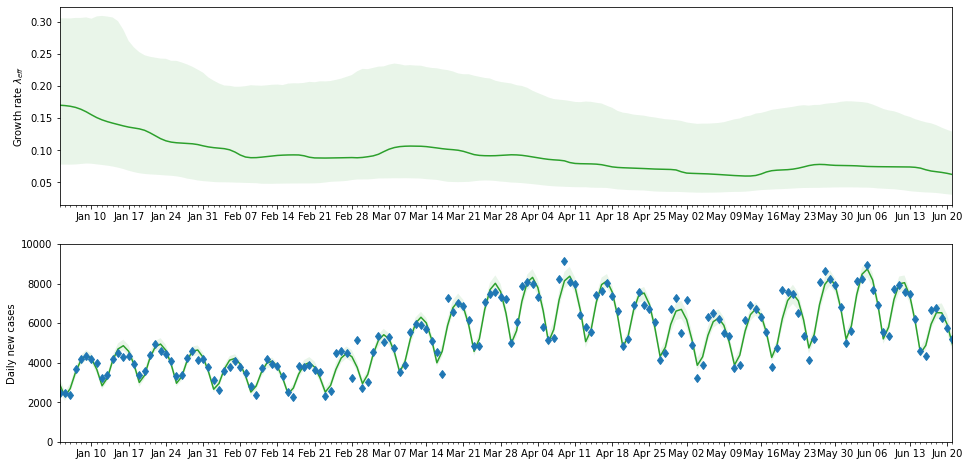

In [21]:
import matplotlib.pyplot as plt
import covid19_inference as cov19
import numpy as np
import pandas as pd

def plot_timeseries(trace, model, key, var=None, ax=None):
    # Get data
    if var is None:
        var = np.array(trace.posterior[key])
        var = var.reshape((var.shape[0]*var.shape[1],) + var.shape[2:])
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(16,8))

    axes = cov19.plot._timeseries(
        x=pd.date_range(this_model.sim_begin,this_model.sim_end),
        y=var[:,:],
        what="model",
        ax=ax)

    return axes

fig, axes = plt.subplots(2,1,figsize=(16,8))

# Plot new_cases
ax = plot_timeseries(trace,this_model,"new_cases",ax=axes[1])
cov19.plot._timeseries(new_cases_obs.index, new_cases_obs,what="data", ax=ax)
ax.set_ylim(0,10000)
ax.set_ylabel("Daily new cases")

# Plot lambda_t
ax = plot_timeseries(trace,this_model,"lambda_t",ax=axes[0])
ax.set_ylabel("Growth rate $\lambda_{eff}$")

for ax in axes:
    _ = ax.set_xlim(this_model.data_begin, this_model.data_end)

In [ ]:
trace.posterior.tau

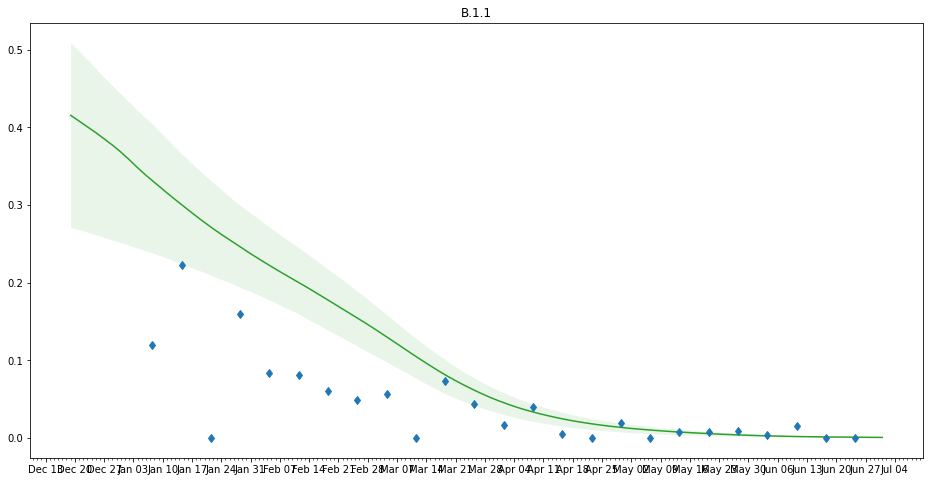

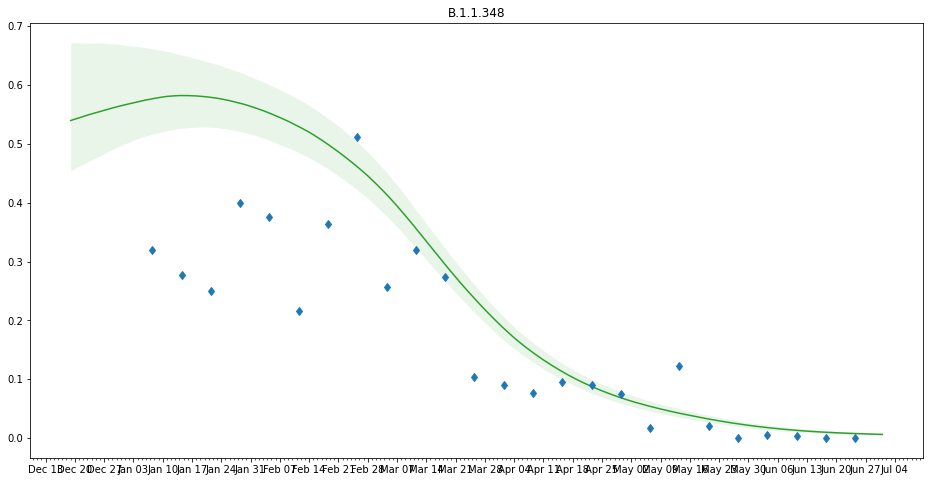

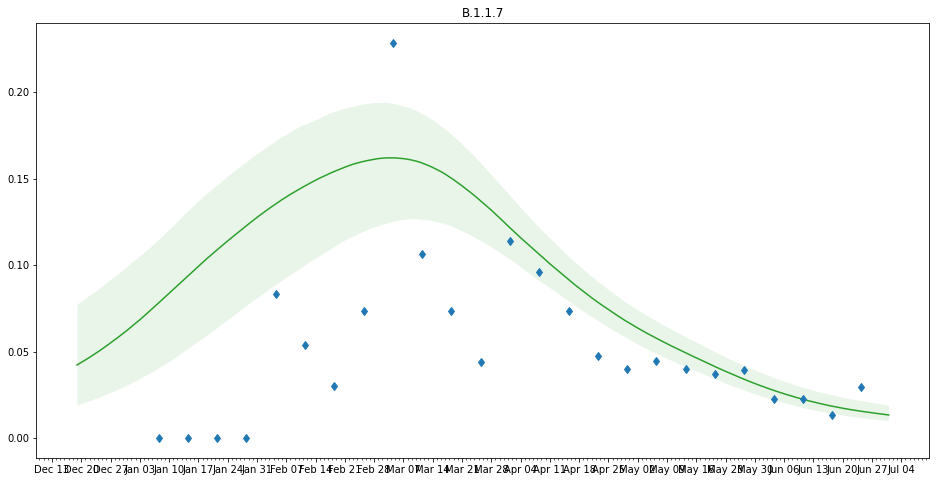

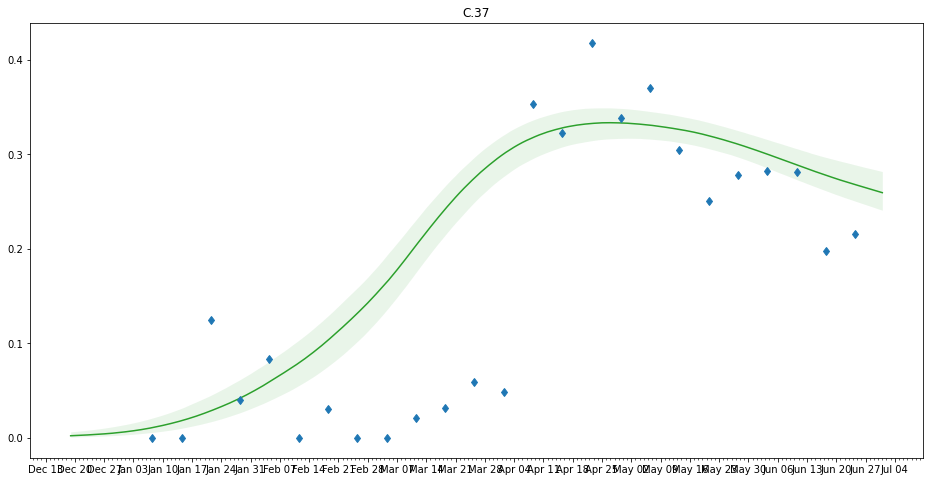

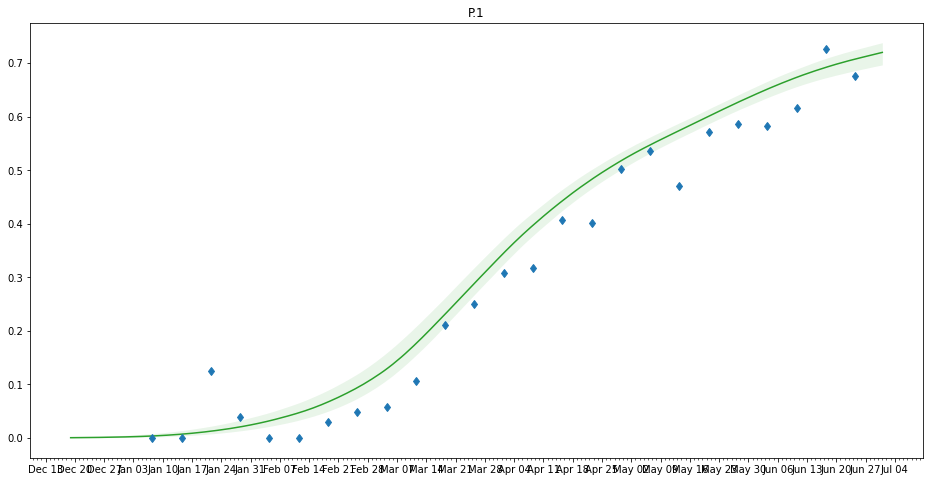

In [22]:
for v,variant in enumerate(variant_names):
    fig, ax = plt.subplots(1,1,figsize=(16,8))
    ax = cov19.plot._timeseries(
            x=pd.date_range(this_model.sim_begin,this_model.sim_end),
            y=np.array(trace.posterior.tau).reshape((trace.posterior.tau.shape[0]*trace.posterior.tau.shape[1],trace.posterior.tau.shape[2],trace.posterior.tau.shape[-1],))[:,:,v],
            what="model",
        ax=ax
    )
    ax = cov19.plot._timeseries(
            x=variants.index + timedelta(days=3.5),
            y=variants[variants.columns[v]]/variants["N_Total"],
            what="data",
        ax=ax
    )
    ax.set_title(variant)

In [18]:
np.array(trace.posterior.tau).reshape((trace.posterior.tau.shape[0]*trace.posterior.tau.shape[1],trace.posterior.tau.shape[2],trace.posterior.tau.shape[-1],))[:,:,v].mean()

0.0027675262946693624

/home/smohr/anaconda3/envs/soccer/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


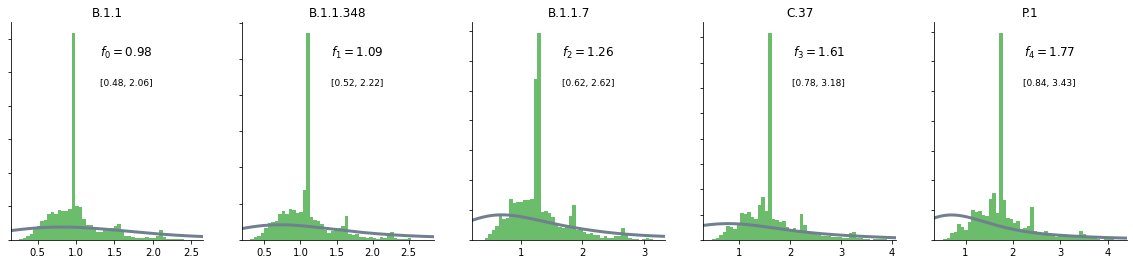

In [23]:
import plot as pl
from rcParams import *

axes = pl.distribution(this_model, trace, "f_v", title="", dist_math="f",)

for i, var in enumerate(variant_names):
    axes[i].set_title(var)

Text(0, 0.5, 'C37')

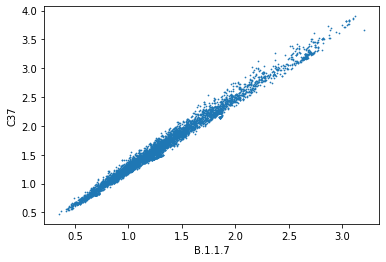

In [19]:
for i in range(5):
    for j in range(5):
        axes[i,j].scatter(np.array(trace.posterior.f_v[:,:,i]).flatten(),np.array(trace.posterior.f_v[:,:,j]).flatten(),s=0.5)
plt.xlabel("B.1.1.7")
plt.ylabel("C37")

### Dirichlet tests

In [ ]:
with pm.Model() as m:
    
    y = pm.Data("y_obs", np.array(variants[variant_names]))
    n = pm.Data("n_obs", np.stack([np.array(variants["N_total"])]*len(variant_names),axis=1))
    
    tau = pm.Dirichlet("tau_w",a=np.ones([16,5]),shape=[16,5])
    tau = pm.Binomial("likelihood", p=frac, observed=y, n=n)
    
    week_to_day_mapping = day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index,fill=True)
    tau = pm.Deterministic("tau",week_to_day_mapping@frac)
    
    trace = pm.sample(return_inferencedata=True)

In [ ]:
az.plot_trace(trace,coords={"tau_dim_0":[60]})

In [ ]:
week_to_day_mapping = day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index,fill=True)
week_to_day_mapping.shape

In [ ]:
a = day_to_week_matrix(this_model.sim_begin,this_model.sim_end,variants.index,fill=True)

In [ ]:
a@np.array(trace.log_likelihood.tau_w[0,0])
